# Introduction

This kernel uses Generative Adversarial Networks (GAN) to recreate Images of Handwritten Digits from the keras mnist dataset.

GAN are able to learn high dimensional and complex data distributions to be able to reproduce synthetic data that looks real.

It has a behemothic inclusion in DeepFake Technology.

The kernel's workflow includes:

- Loading and Prepocessing the Data from keras.mnist
- Building a Generator Model that will create the fake images to fool the Discriminator network into thinking that its real 
- Building a Discriminator Model
- Building a GAN - Combining the Generator and Discriminator Networks
- Training a GAN
- Visualizing the Loss and the Generated Image

All these will be done with Tensorflow 2.x

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt
%matplotlib inline

import sys

import numpy as np
import tqdm

## Loading and Preprocessing the Data

In [2]:
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5

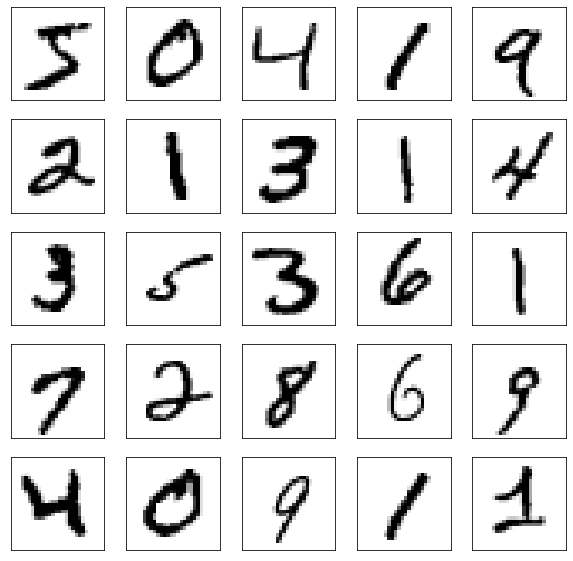

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

Normalize the input values such that each pixel has a value in range [-1,1] as shown below

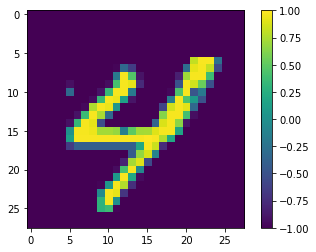

In [4]:
plt.figure()
plt.imshow(X_train[89])
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
# Set the seed for reproducible result
np.random.seed(1000)
randomDim = 10 
X_train = X_train.reshape(60000, 784)

## Building a Generator Model

In [6]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [8]:
# Generator model

# Top layer
generator = Sequential()

# Input layer 
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))

# layer 2
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

# layer 3
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

# Output layer
generator.add(Dense(784, activation='tanh'))

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)              

## Building a Discriminator Model

In [9]:
# Discriminator model

# Top layer
discriminator = Sequential()

# Input layer 
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

# layer 2
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

# layer 3
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

## Building a GAN - Combining the Generator and Discriminator Models

In [10]:
# set disriminator trainable argument to False, to freeze the weights of the Discriminator and train the GAN

discriminator.trainable = False

ganInput = Input(shape=(randomDim,))
a = generator(ganInput)
ganOutput = discriminator(a)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

## Visualizing the Loss and the Generated Image

In [14]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def showGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

## Training a GAN 

In [15]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 1 or e % 20 == 0:
            showGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------------

--------------- Epoch 198 ---------------
--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------


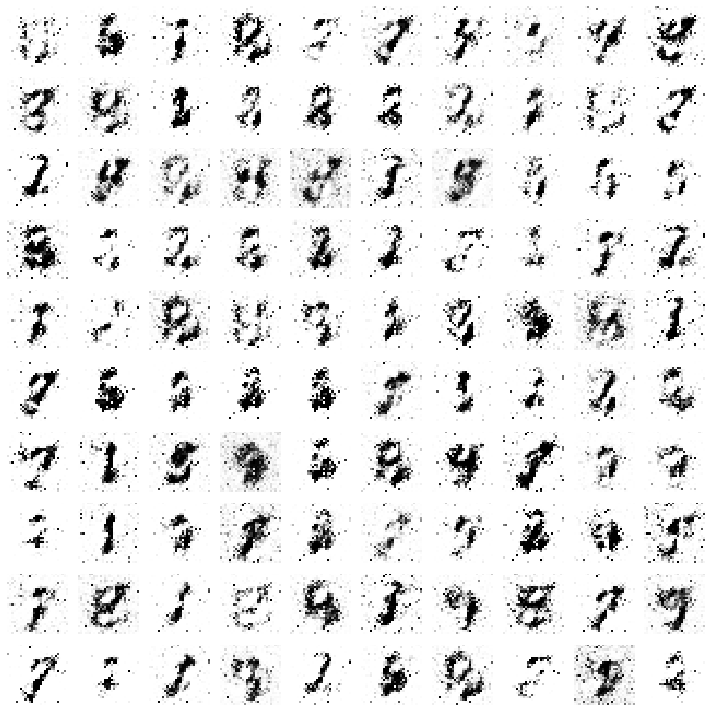

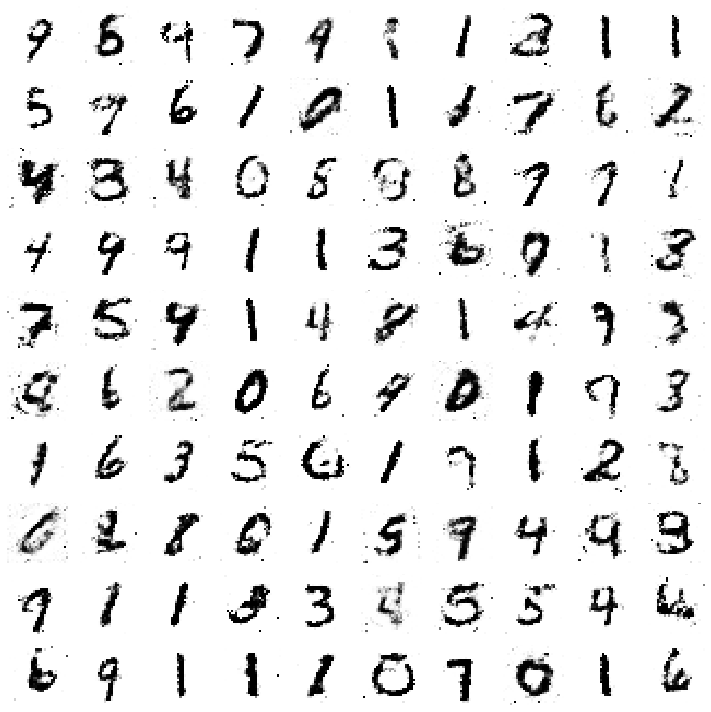

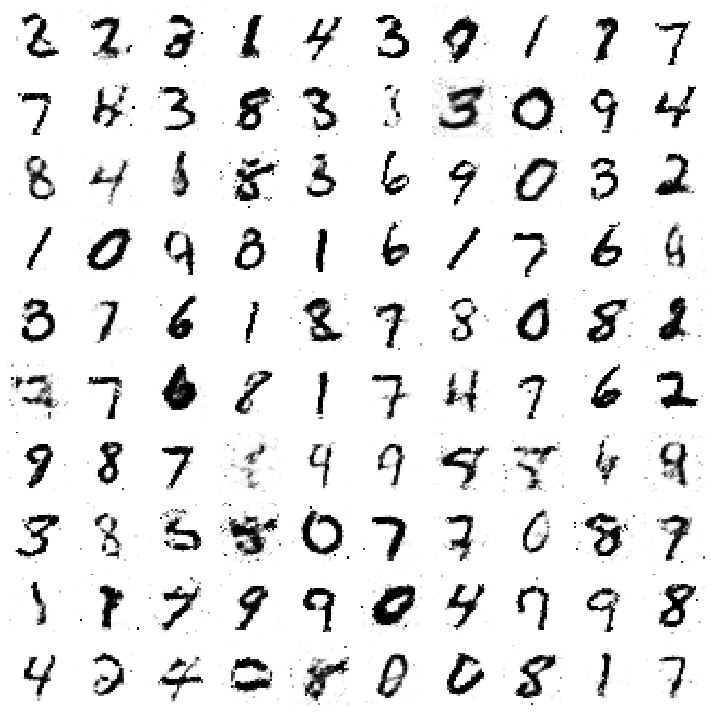

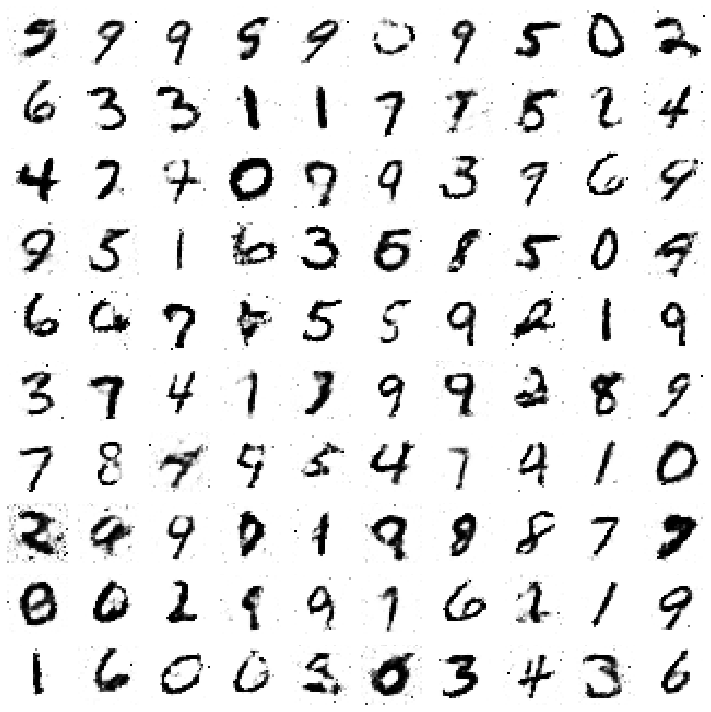

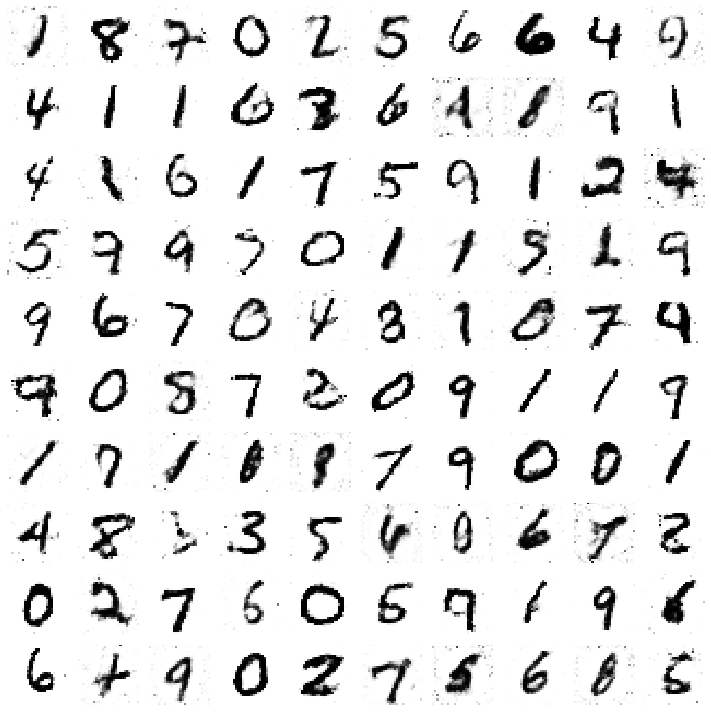

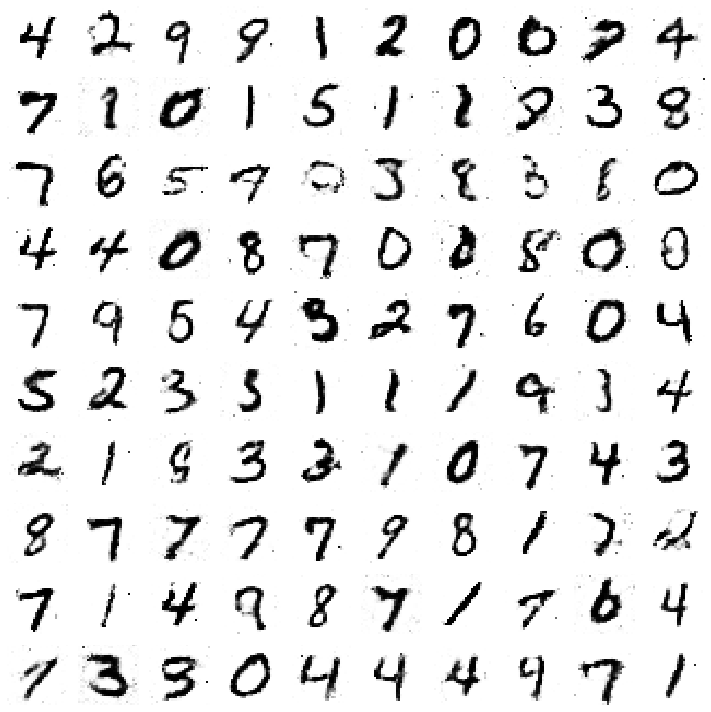

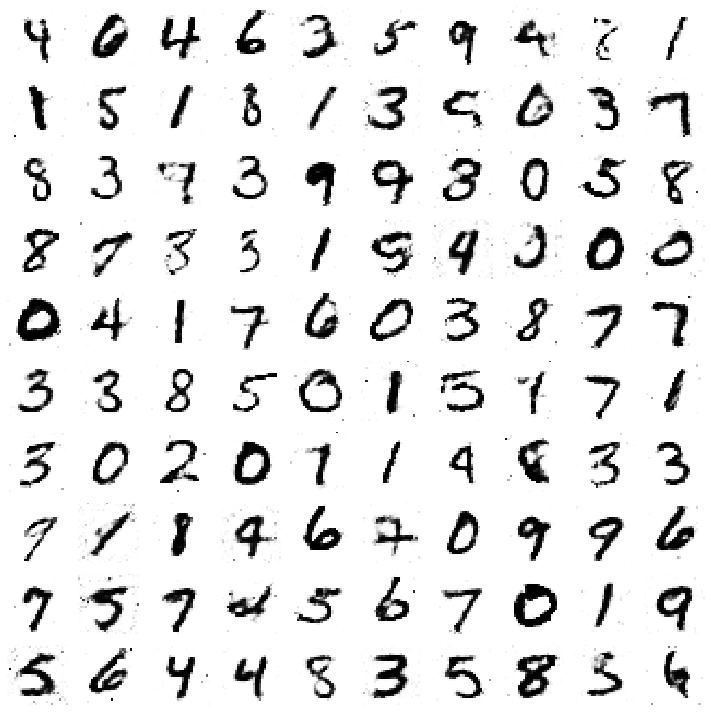

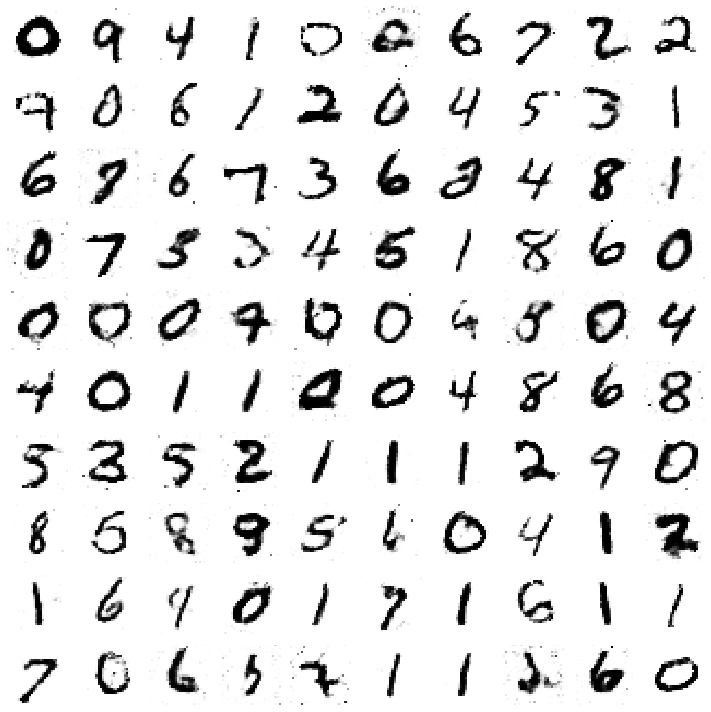

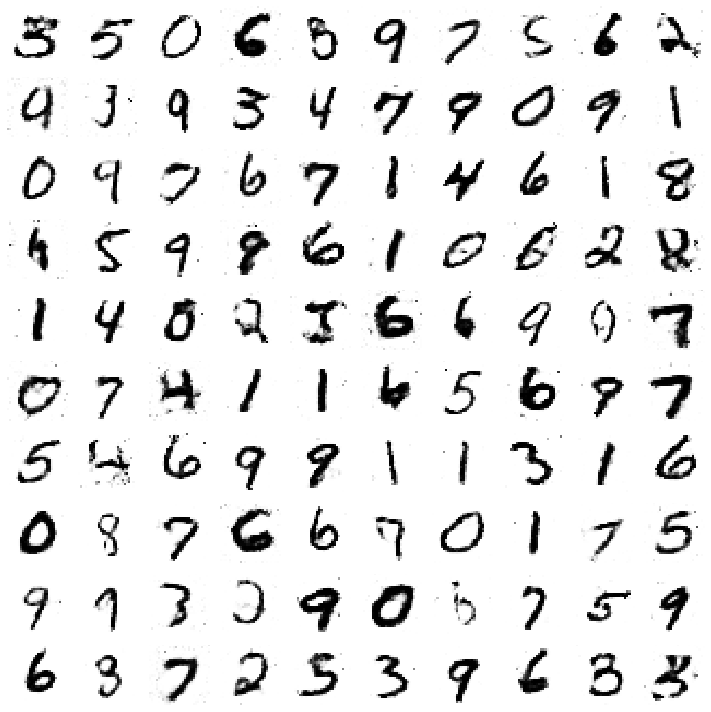

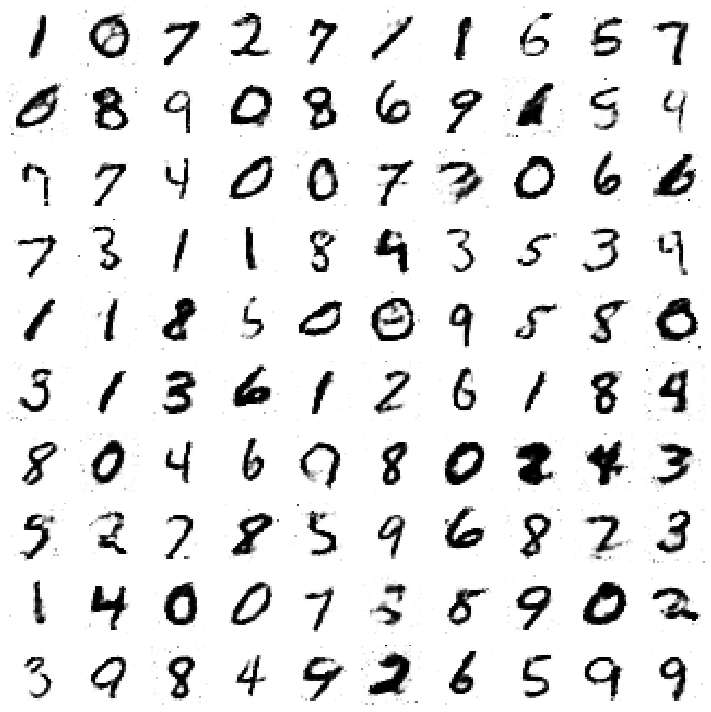

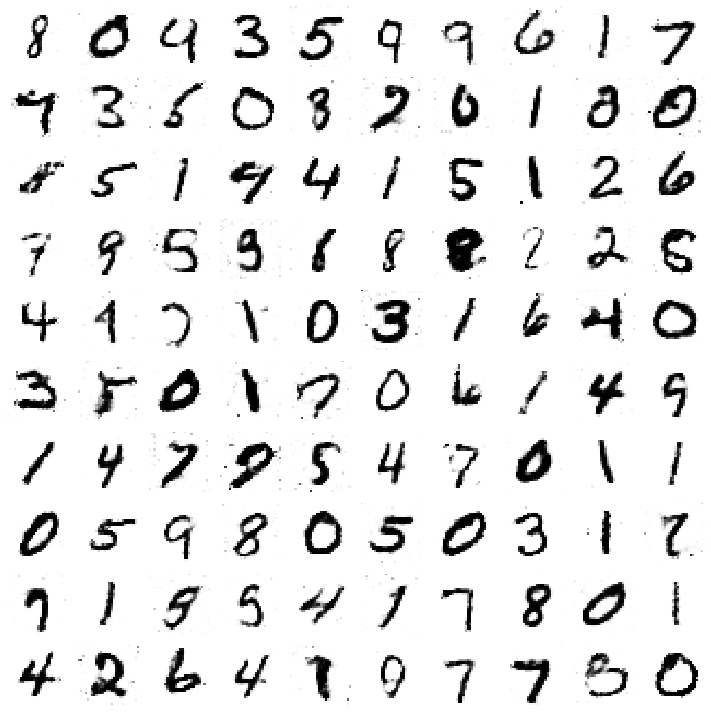

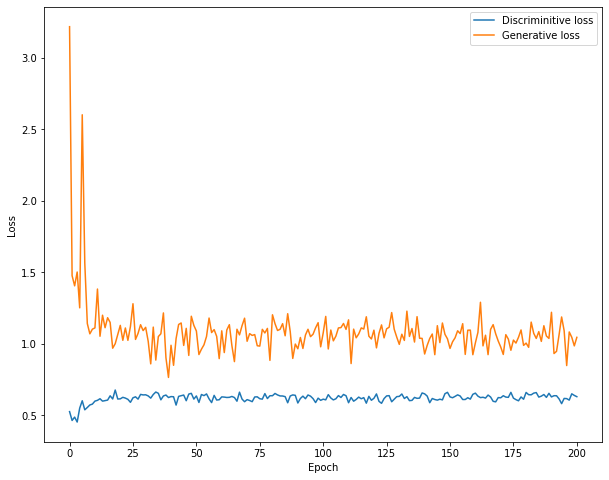

In [16]:
train(200, 128)